# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torchvision
import torch
import lightning.pytorch as pl

from sklearn.decomposition import PCA
from src.model.full_model import SubCellProtModel,SubCellProtModel_bce
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
from src.utils.batch_run_utils import batch_call, get_cell_lines_of_interest, get_isoforms_of_interest, construct_embedding_df
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import time
from enum import Enum
import pdb
import pickle as pk
import math
from src.dataset.dataset import SubCellDatset, DatasetType, CLASSES
from PIL import Image

import sklearn
import sklearn.ensemble
import sklearn.neighbors
import seaborn as sns

fig = plt.figure()

## File locations / hyperparameters

In [2]:
COLLECTION_NAME = "random_splice_isoform_dataset"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
# MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=04-val_combined_loss=0.20.ckpt'


## Preprocessing

In [3]:
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME)
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)


In [7]:
lossMSE=torch.nn.MSELoss()
lossBCE=torch.nn.BCELoss()



In [5]:
alldataset=[train_dataset,val_dataset,test_dataset]
allsize=train_dataset.len+val_dataset.len+test_dataset.len

## compute test loss by cell line & plot examples

In [5]:
savedir='plots_randomSelection/losses'

In [6]:
alldatanames=['train_','eval_','test_']

In [30]:
allTestLosses_mse={}
allTestLosses_mseEven={}
allTestPnames={}
allTestCellID={}
allTestCounts={}
allTestCellLine={}
for loc in np.array(sorted(CLASSES[0])):
    allTestLosses_mse[loc]=np.zeros(allsize)+np.inf
    allTestLosses_mseEven[loc]=np.zeros(allsize)+np.inf
    allTestLosses_bce[loc]=np.zeros(allsize)+np.inf
    allTestPnames[loc]=np.zeros(allsize).astype(str)
    allTestCellID[loc]=np.zeros(allsize).astype(str)
    allTestCounts[loc]=0
    allTestCellLine[loc]=np.zeros(allsize).astype(str)
for d in range(3):
    print('dataset',d)
    curr_dataset=alldataset[d]
    for i in range(curr_dataset.len):
        metadata=get_data(alldatanames[d]+str(i), Retrieval_Data.METADATA)
        cl=metadata['cell_line']
        X_esm2_encoding, X_protein_len, X_landmark_stains, y_multilabel, y_antibody_stain=curr_dataset[i]
        y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
            (
                X_esm2_encoding.unsqueeze(0),
                torch.Tensor([X_protein_len]),
                torch.from_numpy(X_landmark_stains).unsqueeze(0),
                None,
                None,
            ),
            batch_idx=0,
        )
        mse_curr=lossMSE(y_pred_antibody_stain,torch.tensor(y_antibody_stain.reshape(1,1,128,128))).detach().numpy()

        y_predminmax=(y_pred_antibody_stain-torch.min(y_pred_antibody_stain))/(torch.max(y_pred_antibody_stain)-torch.min(y_pred_antibody_stain))

        locs=np.array(sorted(CLASSES[0]))[y_multilabel.astype(bool)]
        
        refMask=np.sum(X_landmark_stains,axis=0)>0
        refMask[refMask]=np.mean(y_pred_antibody_stain.detach().numpy())
        mse_even=lossMSE(torch.tensor(refMask.reshape(1,1,128,128)),torch.tensor(y_antibody_stain.reshape(1,1,128,128))).detach().numpy()



        for loc in locs:
            cCount=allTestCounts[loc]
            allTestLosses_mse[loc][cCount]=mse_curr
            allTestLosses_mseEven[loc][cCount]=mse_even
            allTestPnames[loc][cCount]=metadata['splice_isoform_id']
            allTestCellID[loc][cCount]=alldatanames[d]+str(i)
            allTestCounts[loc]+=1
            allTestCellLine[loc][cCount]=cl
        if i%200==0:
            print(i)

dataset 0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
1830

In [127]:
import seaborn as sns

In [ ]:
with open('isoform_grouping_train_alphabetical', 'rb') as output:
    isoform_grouping_train=pk.load(output)

In [ ]:
for loc in np.array(sorted(CLASSES[0])):
    if allTestCounts[loc]==0:
        continue
    print(loc)
    allTestLosses_mse[loc]=allTestLosses_mse[loc][:allTestCounts[loc]]
    allTestLosses_mseEven[loc]=allTestLosses_mseEven[loc][:allTestCounts[loc]]
    allTestLosses_bce[loc]=allTestLosses_bce[loc][:allTestCounts[loc]]
    allTestPnames[loc]=allTestPnames[loc][:allTestCounts[loc]]
    allTestCellID[loc]=allTestCellID[loc][:allTestCounts[loc]]
    trainGenes=np.intersect1d(allTestPnames[loc],isoform_grouping_train)
    testIdx=np.repeat(True,allTestCounts[loc])
    for tg in trainGenes:
        testIdx[allTestPnames[loc]==tg]=False
    allTestLosses_mse[loc]=allTestLosses_mse[loc][testIdx]
    allTestLosses_mseEven[loc]=allTestLosses_mseEven[loc][testIdx]
    allTestLosses_bce[loc]=allTestLosses_bce[loc][testIdx]
    allTestPnames[loc]=allTestPnames[loc][testIdx]
    allTestCellID[loc]=allTestCellID[loc][testIdx]
    
allTestLoc=np.array([])
allTestLosses_mse_comb=np.array([])
allTestLosses_mseEven_comb=np.array([])
allTestLosses_bce_comb=np.array([])
for loc in np.array(sorted(CLASSES[0])):
    if allTestCounts[loc]==0:
        continue
    allTestLoc=np.concatenate((allTestLoc,np.repeat(loc,allTestLosses_mse[loc].size)))
    allTestLosses_mse_comb=np.concatenate((allTestLosses_mse_comb,allTestLosses_mse[loc]))
    allTestLosses_mseEven_comb=np.concatenate((allTestLosses_mseEven_comb,allTestLosses_mseEven[loc]))
    allTestLosses_bce_comb=np.concatenate((allTestLosses_bce_comb,allTestLosses_bce[loc]))

In [ ]:
np.median(allTestLosses_mseEven_mean)

In [ ]:
np.median(allTestLosses_mse_comb)

In [ ]:


plt.figure(figsize=(4,5))
df=pd.DataFrame(data={'loc':allTestLoc,'mse':allTestLosses_mse_comb})
sns.set(font_scale = 1)
ax=sns.violinplot(df,x='mse',y='loc',cut=0,linewidth=1.8)
ax.scatter(x=allTestLosses_mseEven_mean,y=np.arange(len(allTestLosses_mseEven_mean)),c='red',s=7)
ax.set_xlim(0,0.8)

## plot nuclear localization

In [8]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from skimage.filters import gaussian
from skimage.measure import label
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage.measurements import center_of_mass

2508730219.py (7): Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.


In [9]:
model_stardist = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2024-01-13 09:41:07.494156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 09:41:07.496960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [39]:
allTestNucProp_pred=np.zeros(allsize)
allTestNucProp_true=np.zeros(allsize)
allTestPnames=np.zeros(allsize).astype(str)
allTestCL=np.zeros(allsize).astype(str)
j=0
for d in range(3):
    print('dataset',d)
    curr_dataset=alldataset[d]
    for i in range(curr_dataset.len):
        X_esm2_encoding, X_protein_len, X_landmark_stains, y_multilabel, y_antibody_stain=curr_dataset[i]
        y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
            (
                X_esm2_encoding.unsqueeze(0),
                torch.Tensor([X_protein_len]),
                torch.from_numpy(X_landmark_stains).unsqueeze(0),
                None,
                None,
            ),
            batch_idx=0,
        )
        labeled_nuclei, linfo = model_stardist.predict_instances(gaussian(normalize(X_landmark_stains[0])))
        nuc_mask=np.zeros((128,128))
        nuc_mask[labeled_nuclei>0]=1

        allTestNucProp_pred[j]=np.sum(nuc_mask*y_pred_antibody_stain.detach().numpy())/np.sum(y_pred_antibody_stain.detach().numpy())
        allTestNucProp_true[j]=np.sum(nuc_mask*y_antibody_stain)/np.sum(y_antibody_stain)

        metadata=get_data(alldatanames[d]+str(i), Retrieval_Data.METADATA)
        allTestPnames[j]=metadata['splice_isoform_id']
        allTestCL[j]=metadata['cell_line']

        if i%100==0:
            print(i)
        j+=1


dataset 0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
1830

In [11]:
with open('isoform_grouping_train_alphabetical', 'rb') as output:
    isoform_grouping_train=pk.load(output)

In [13]:
trainGenes=np.intersect1d(allTestPnames,isoform_grouping_train)
testIdx=np.repeat(True,allTestPnames.size)
for tg in trainGenes:
    testIdx[allTestPnames==tg]=False

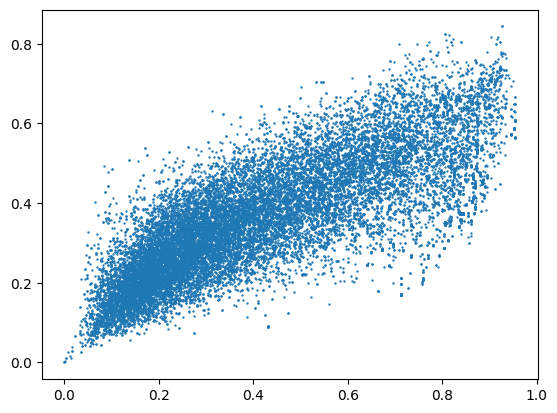

In [14]:
plt.scatter(allTestNucProp_true[testIdx],allTestNucProp_pred[testIdx],s=0.5)

In [15]:
from scipy import stats

In [16]:
corr,pval=stats.pearsonr(allTestNucProp_true[testIdx],allTestNucProp_pred[testIdx])
print(corr)
print(pval)

0.793735399321868
0.0


In [59]:
savedir_log='log_randomSelection/'


In [38]:
with open(os.path.join(savedir_log,'testIdx'), 'wb') as output:
    pk.dump(testIdx, output, pk.HIGHEST_PROTOCOL)

In [19]:
p_cl_pair=np.copy(allTestPnames[testIdx])
for p in range(p_cl_pair.size):
    p_cl_pair[p]=p_cl_pair[p]+'_'+allTestCL[testIdx][p].lower()

In [20]:
pclnames,pcounts=np.unique(p_cl_pair,return_counts=True)
pclnames=pclnames[pcounts>10]
pclvar_pred=np.zeros(pclnames.size)
pclmean_pred=np.zeros(pclnames.size)
pclvar_true=np.zeros(pclnames.size)
pclmean_true=np.zeros(pclnames.size)
pclerror=np.zeros(pclnames.size)
allError_nuc=allTestNucProp_pred[testIdx]-allTestNucProp_true[testIdx]
for p in range(pclnames.size):
    pclvar_pred[p]=np.var(allTestNucProp_pred[testIdx][p_cl_pair==pclnames[p]])
    pclvar_true[p]=np.var(allTestNucProp_true[testIdx][p_cl_pair==pclnames[p]])
    
    pclmean_pred[p]=np.mean(allTestNucProp_pred[testIdx][p_cl_pair==pclnames[p]])
    pclmean_true[p]=np.mean(allTestNucProp_true[testIdx][p_cl_pair==pclnames[p]])
    
    pclerror[p]=np.mean(np.abs(allError_nuc[p_cl_pair==pclnames[p]]))

In [21]:
top_var_idx=np.argsort(-pclvar_pred)
top_var_idx_true=np.argsort(-pclvar_true)
top_var_idx_errorSub=np.argsort(-(np.sqrt(pclvar_pred)-pclerror))
nplot=60
topPairs_pred=pclnames[top_var_idx[:nplot]]
topPairs_true=pclnames[top_var_idx_true[:nplot]]
topPairs_pred_errorSub=pclnames[top_var_idx_errorSub[:nplot]]

In [24]:
np.sum(testIdx)

24007

In [27]:
np.unique(allTestPnames[testIdx]).shape

(556,)

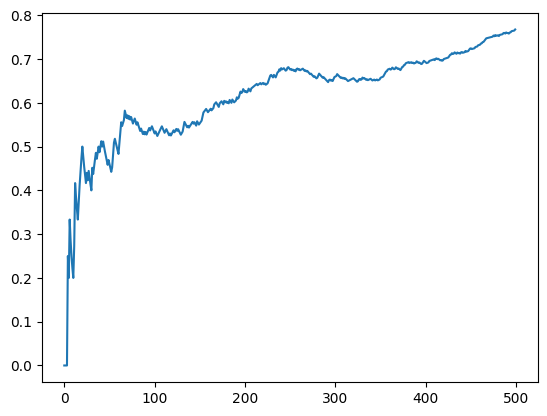

In [22]:
#consensus curve
consensusCount=np.zeros(500)
for nplot_i in range(1,500):
    topPairs_pred=pclnames[top_var_idx[:nplot_i]]
    topPairs_true=pclnames[top_var_idx_true[:nplot_i]]
    consensusCount[nplot_i]=np.intersect1d(topPairs_pred,topPairs_true).size/nplot_i
    
plt.plot(np.arange(500),consensusCount)

(0.0, 1.0)

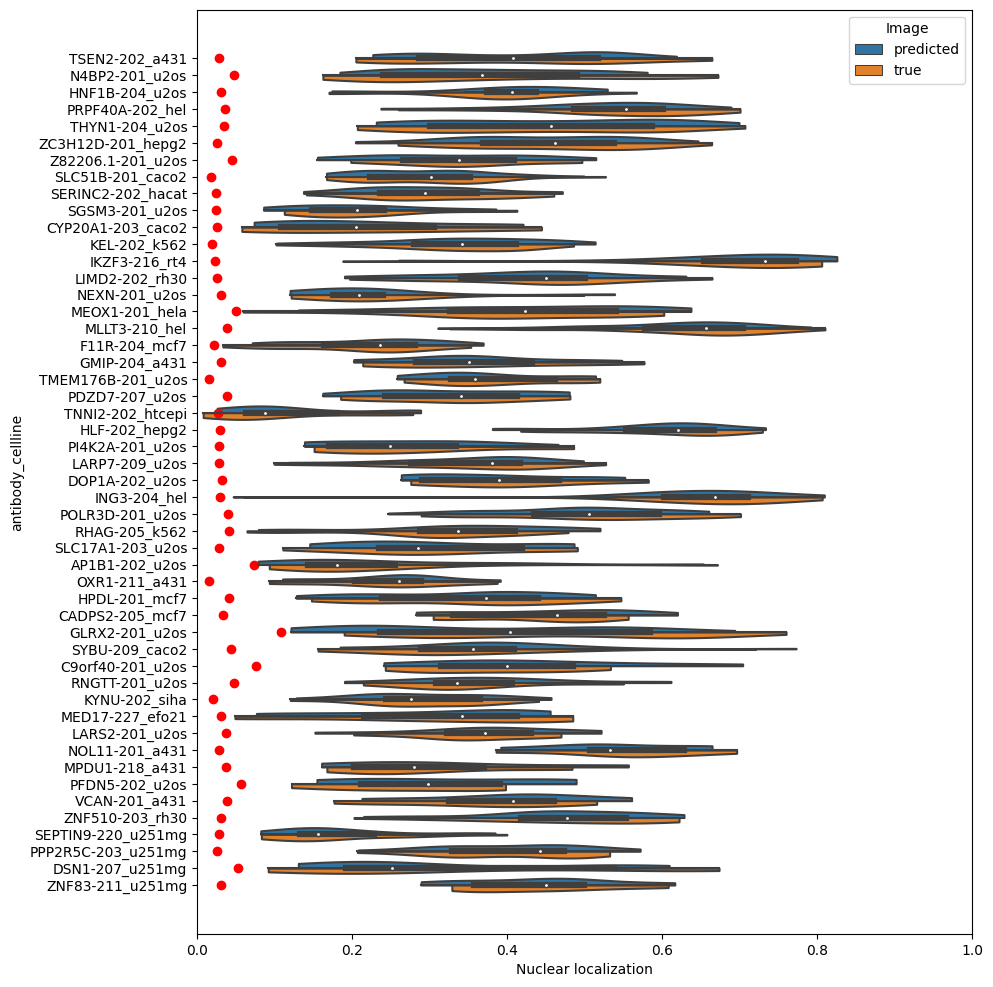

In [29]:
#test only
top_var_idx=np.argsort(-pclvar_pred)
top_var_idx_true=np.argsort(-pclvar_true)
top_var_idx_errorSub=np.argsort(-(np.sqrt(pclvar_pred)-pclerror))
nplot=60
topPairs_pred=pclnames[top_var_idx[:nplot]]
topPairs_true=pclnames[top_var_idx_true[:nplot]]
topPairs_pred_errorSub=pclnames[top_var_idx_errorSub[:nplot]]

topPairs_pred_errorSub_idx=np.repeat(False,allTestNucProp_pred[testIdx].size)
for p in topPairs_pred_errorSub:
    topPairs_pred_errorSub_idx[p_cl_pair==p]=True
    
pltorder,pltorderindex=np.unique(p_cl_pair[topPairs_pred_errorSub_idx],return_index=True)
errorIdx=np.zeros(60).astype(int)
for i in range(60):
    errorIdx[i]=np.arange(pclnames.size)[pclnames==pltorder[np.argsort(pltorderindex)][i]]
    
nplot=50
currTopPairs=np.repeat('-',nplot).astype(object)
currTopPairs_predNames=np.repeat('-',nplot).astype(object)
topPairs_pred_errorSub_idx_unique=np.repeat(False,allTestNucProp_pred[testIdx].size)
_count=0
for pidx in range(top_var_idx_errorSub.size):
    p=pclnames[top_var_idx_errorSub[pidx]]
    if p.split('-')[0] not in currTopPairs:
        currTopPairs[_count]=p.split('-')[0]
        currTopPairs_predNames[_count]=p
        topPairs_pred_errorSub_idx_unique[p_cl_pair==p]=True
        _count+=1
    if _count==nplot:
        break
        
nplot=50
currTopPairs_true=np.repeat('-',nplot).astype(object)
currTopPairs_trueNames=np.repeat('-',nplot).astype(object)
topPairs_true_idx_unique=np.repeat(False,allTestNucProp_pred[testIdx].size)
_count=0
for pidx in range(top_var_idx.size):
    p=pclnames[top_var_idx_true[pidx]]
    if p.split('-')[0] not in currTopPairs_true:
        currTopPairs_true[_count]=p.split('-')[0]
        currTopPairs_trueNames[_count]=p
        topPairs_true_idx_unique[p_cl_pair==p]=True
        _count+=1
    if _count==nplot:
        break
        
top2plot,plotPredIdx,plotTrueIdx=np.intersect1d(currTopPairs,currTopPairs_true,return_indices=True)

pltorder_unique,pltorderindex_unique=np.unique(p_cl_pair[topPairs_pred_errorSub_idx_unique],return_index=True)
errorIdx_unique=np.zeros(pltorderindex_unique.size).astype(int)
for i in range(pltorderindex_unique.size):
    errorIdx_unique[i]=np.arange(pclnames.size)[pclnames==pltorder_unique[np.argsort(pltorderindex_unique)][i]]
    


plt.figure(figsize=(10,12))
names=np.concatenate((np.repeat('predicted',np.sum(topPairs_pred_errorSub_idx_unique)),np.repeat('true',np.sum(topPairs_pred_errorSub_idx_unique))))
df=pd.DataFrame(data={'antibody_cellline':np.concatenate((p_cl_pair[topPairs_pred_errorSub_idx_unique],p_cl_pair[topPairs_pred_errorSub_idx_unique])),'Nuclear localization':np.concatenate((allTestNucProp_pred[testIdx][topPairs_pred_errorSub_idx_unique],allTestNucProp_true[testIdx][topPairs_pred_errorSub_idx_unique])),'Image':names})
ax=sns.violinplot(df,x='Nuclear localization',y='antibody_cellline',hue='Image',split=True,cut=0)
ax.scatter(x=pclerror[errorIdx_unique],y=np.arange(nplot),c='red')
plt.xlim(0,1)



In [34]:
savedir_log='log_randomSelection/'
with open(os.path.join(savedir_log,'currTopPairs_errorSub_testonly'), 'wb') as output:
    pk.dump(currTopPairs, output, pk.HIGHEST_PROTOCOL)
with open(os.path.join(savedir_log,'currTopPairs_true_errorSub_testonly'), 'wb') as output:
    pk.dump(currTopPairs_true, output, pk.HIGHEST_PROTOCOL)

(0.0, 1.0)

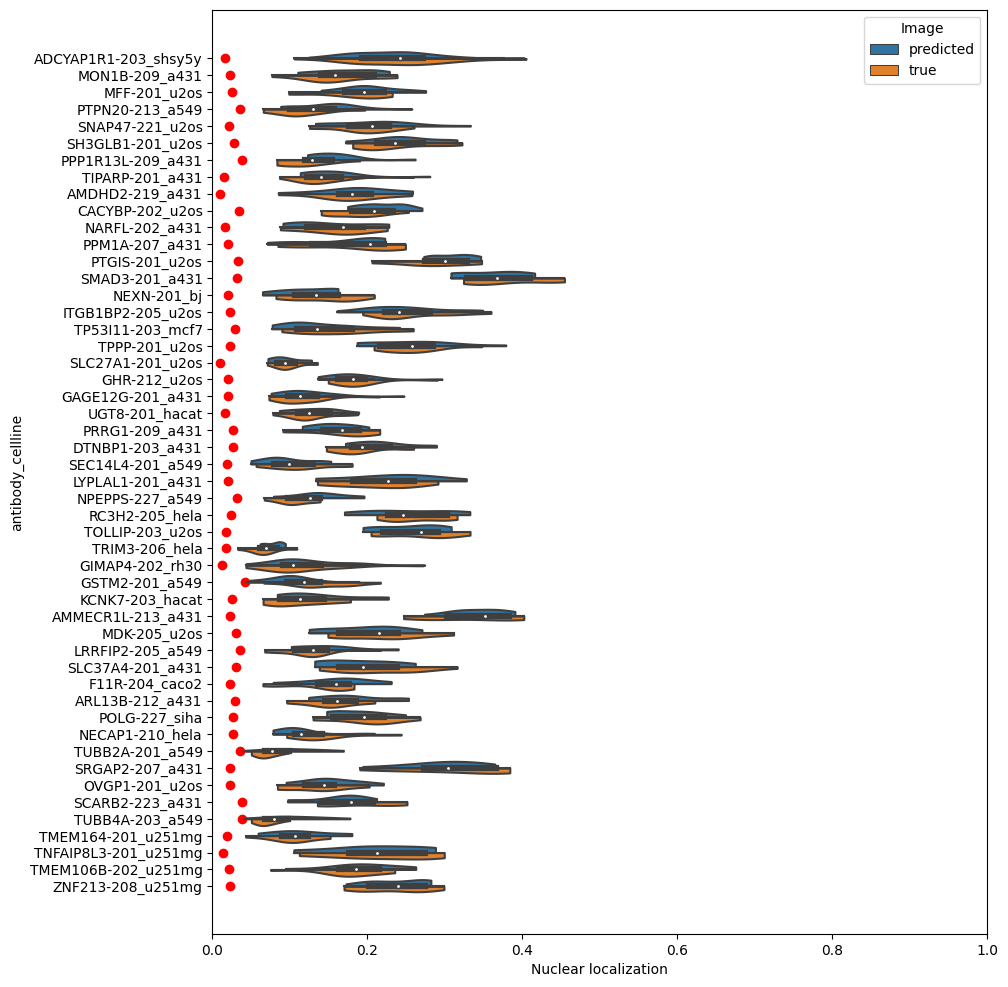

In [36]:
#least variable - test only
least_var_idx=np.argsort(pclvar_pred)
least_var_idx_true=np.argsort(pclvar_true)
least_var_idx_errorAdd=np.argsort(np.sqrt(pclvar_pred)+pclerror)
nplot=60
leastPairs_pred=pclnames[least_var_idx[:nplot]]
leastPairs_true=pclnames[least_var_idx_true[:nplot]]
leastPairs_pred_errorSub=pclnames[least_var_idx_errorAdd[:nplot]]

nplot=50
currLeastPairs=np.repeat('-',nplot).astype(object)
currLeastPairs_predNames=np.repeat('-',nplot).astype(object)
leastPairs_pred_errorAdd_idx_unique=np.repeat(False,np.sum(testIdx))
_count=0
for pidx in range(least_var_idx_errorAdd.size):
    p=pclnames[least_var_idx_errorAdd[pidx]]
    if p.split('-')[0] not in currLeastPairs:
        currLeastPairs[_count]=p.split('-')[0]
        currLeastPairs_predNames[_count]=p
        leastPairs_pred_errorAdd_idx_unique[p_cl_pair==p]=True
        _count+=1
    if _count==nplot:
        break
        
nplot=50
currLeastPairs_true=np.repeat('-',nplot).astype(object)
currLeastPairs_trueNames=np.repeat('-',nplot).astype(object)
leastPairs_true_idx_unique=np.repeat(False,np.sum(testIdx))
_count=0
for pidx in range(least_var_idx.size):
    p=pclnames[least_var_idx_true[pidx]]
    if p.split('-')[0] not in currLeastPairs_true:
        currLeastPairs_true[_count]=p.split('-')[0]
        currLeastPairs_trueNames[_count]=p
        leastPairs_true_idx_unique[p_cl_pair==p]=True
        _count+=1
    if _count==nplot:
        break
        
least2plot,plotPredIdx,plotTrueIdx=np.intersect1d(currLeastPairs,currLeastPairs_true,return_indices=True)

pltorder_unique,pltorderindex_unique=np.unique(p_cl_pair[leastPairs_pred_errorAdd_idx_unique],return_index=True)
errorIdx_unique=np.zeros(pltorderindex_unique.size).astype(int)
for i in range(pltorderindex_unique.size):
    errorIdx_unique[i]=np.arange(pclnames.size)[pclnames==pltorder_unique[np.argsort(pltorderindex_unique)][i]]
    


plt.figure(figsize=(10,12))
names=np.concatenate((np.repeat('predicted',np.sum(leastPairs_pred_errorAdd_idx_unique)),np.repeat('true',np.sum(leastPairs_pred_errorAdd_idx_unique))))
df=pd.DataFrame(data={'antibody_cellline':np.concatenate((p_cl_pair[leastPairs_pred_errorAdd_idx_unique],p_cl_pair[leastPairs_pred_errorAdd_idx_unique])),'Nuclear localization':np.concatenate((allTestNucProp_pred[testIdx][leastPairs_pred_errorAdd_idx_unique],allTestNucProp_true[testIdx][leastPairs_pred_errorAdd_idx_unique])),'Image':names})
ax=sns.violinplot(df,x='Nuclear localization',y='antibody_cellline',hue='Image',split=True,cut=0)
ax.scatter(x=pclerror[errorIdx_unique],y=np.arange(nplot),c='red')
plt.xlim(0,1)

In [37]:
with open(os.path.join(savedir_log,'currLeastPairs_errorSub_testonly'), 'wb') as output:
    pk.dump(currLeastPairs, output, pk.HIGHEST_PROTOCOL)
with open(os.path.join(savedir_log,'currLeastPairs_true_errorSub_testonly'), 'wb') as output:
    pk.dump(currLeastPairs_true, output, pk.HIGHEST_PROTOCOL)

### variance of cell line mean nuclear localization

In [117]:
from pymongo import MongoClient
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    isoform_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$splice_isoform_id", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [118]:
cell_line_grouping = None
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    cell_line_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$cell_line", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [44]:
cellIDbyCellLine={}
for clidx in cell_line_grouping:
    if clidx['_id'] in testCellLines:
        cellIDbyCellLine[clidx['_id']]=np.array(clidx['ids'])

In [45]:
import time

In [46]:
nucProp_landmarks={}
nucProp_mask={}
nsamples_all=200
for clidx in range(testCellLines.size):
    cl=testCellLines[clidx]
    print(cl)

    nsamples=min(nsamples_all,cellIDbyCellLine[cl].size)
    sampleIdx=np.arange(cellIDbyCellLine[cl].size)
    np.random.seed(3)
    np.random.shuffle(sampleIdx)
    cellID_cl=cellIDbyCellLine[cl][sampleIdx[:nsamples]]
    
    nucProp_landmarks[cl]=[None]*nsamples
    nucProp_mask[cl]=[None]*nsamples
    for cIdx in range(nsamples):
        X_landmark_stains = get_data(cellID_cl[cIdx], Retrieval_Data.CELL_IMAGE)
        labeled_nuclei, linfo = model_stardist.predict_instances(gaussian(normalize(X_landmark_stains[0])))
        nuc_mask=np.zeros((128,128))
        nuc_mask[labeled_nuclei>0]=1
        
        
        nucProp_landmarks[cl][cIdx]=X_landmark_stains
        nucProp_mask[cl][cIdx]=nuc_mask
        

MCF7
U251MG
HEK293


In [ ]:
#threshold
#Fei's cell line
highThresh=2/3
lowThresh=1/3
nucProp_p_cl_thresh=np.zeros((len(isoform_grouping),testCellLines.size))

nsamples_all=60
for clidx in range(testCellLines.size):
    cl=testCellLines[clidx]
    print(cl)

    for pidx in range(len(isoform_grouping)):
        p=isoform_grouping[pidx]['_id']
        print(p)
        X_esm2_encoding, X_protein_len = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)

        nsamples=min(nsamples_all,len(nucProp_landmarks[cl]))
        nucPropCurr=np.zeros(nsamples)
        tstart=time.time()
        for cIdx in range(nsamples):
            X_landmark_stains = nucProp_landmarks[cl][cIdx]
            nuc_mask=nucProp_mask[cl][cIdx]
            if cIdx%10==0:
                print(cIdx)

            y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
                (
                    X_esm2_encoding.unsqueeze(0),
                    torch.Tensor([X_protein_len]),
                    torch.from_numpy(X_landmark_stains).unsqueeze(0),
                    None,
                    None,
                ),
                batch_idx=0,
            )
            nucPropRaw=np.sum(nuc_mask*y_pred_antibody_stain.detach().numpy())/np.sum(y_pred_antibody_stain.detach().numpy())
            if nucPropRaw>highThresh:
                nucPropCurr[cIdx]=1
            elif nucPropRaw<lowThresh:
                nucPropCurr[cIdx]=-1
        print(time.time()-tstart)
        nucProp_p_cl_thresh[pidx,clidx]=np.mean(nucPropCurr)

MCF7
LAT2-202
0
10
20
30
40
50
1.8055553436279297
CD81-208
0
10
20
30
40
50
1.7978887557983398
PARN-216
0
10
20
30
40
50
1.7965683937072754
SCARB2-223
0
10
20
30
40
50
1.793229103088379
DNAAF1-201
0
10
20
30
40
50
1.7988662719726562
MPDU1-218
0
10
20
30
40
50
1.8251209259033203
RNPS1-223
0
10
20
30
40
50
1.8188536167144775
ZSCAN5B-203
0
10
20
30
40
50
1.8173906803131104
PDHB-206
0
10
20
30
40
50
1.871168613433838
PLCE1-210
0
10
20
30
40
50
1.8721020221710205
CSPP1-228
0
10
20
30
40
50
1.8697428703308105
OAS1-207
0
10
20
30
40
50
1.8718857765197754
ZNF83-211
0
10
20
30
40
50
1.8740904331207275
BNIP3L-207
0
10
20
30
40
50
1.8688912391662598
JADE1-201
0
10
20
30
40
50
1.9038257598876953
NEIL1-206
0
10
20
30
40
50
1.8585994243621826
LARS2-201
0
10
20
30
40
50
1.8596808910369873
SEPHS1-202
0
10
20
30
40
50
1.8673253059387207
TMTC1-203
0
10
20
30
40
50
1.863001823425293
TRAPPC8-205
0
10
20
30
40
50
1.881026029586792
PFKM-210
0
10
20
30
40
50
1.8936588764190674
TUBA1A-209
0
10
20
30
40
50
1.8

10
20
30
40
50
1.7761926651000977
PTPN20-213
0
10
20
30
40
50
1.7763779163360596
DSN1-207
0
10
20
30
40
50
1.7902679443359375
EBF1-202
0
10
20
30
40
50
1.8423948287963867
PTPN14-201
0
10
20
30
40
50
1.7873961925506592
LRRFIP2-205
0
10
20
30
40
50
1.783740520477295
ATF4-208
0
10
20
30
40
50
1.7933101654052734
CCDC71-201
0
10
20
30
40
50
1.8218626976013184
VCAN-201
0
10
20
30
40
50
1.8044123649597168
SAP18-207
0
10
20
30
40
50
1.8074426651000977
ZNF280A-201
0
10
20
30
40
50
1.7992074489593506
NXF3-201
0
10
20
30
40
50
1.7800426483154297
C8orf33-201
0
10
20
30
40
50
1.7848541736602783
BIN2-210
0
10
20
30
40
50
1.7902905941009521
CEP290-221
0
10
20
30
40
50
1.810361623764038
AKIRIN1-204
0
10
20
30
40
50
1.8011524677276611
PDCD6-201
0
10
20
30
40
50
1.7693591117858887
MIA2-210
0
10
20
30
40
50
1.818627119064331
STX16-208
0
10
20
30
40
50
1.8128151893615723
TRAF5-202
0
10
20
30
40
50
1.8081622123718262
C11orf1-204
0
10
20
30
40
50
1.7990212440490723
CCDC74A-202
0
10
20
30
40
50
1.81681084632

10
20
30
40
50
1.804901123046875
P3H1-204
0
10
20
30
40
50
1.8014671802520752
COL4A3BP-222
0
10
20
30
40
50
1.8034381866455078
SGSM3-201
0
10
20
30
40
50
1.801802396774292
MARVELD2-208
0
10
20
30
40
50
1.6546375751495361
XPO1-226
0
10
20
30
40
50
1.7612409591674805
AMPD3-202
0
10
20
30
40
50
1.759934902191162
GPR161-208
0
10
20
30
40
50
1.758667230606079
C1QTNF7-202
0
10
20
30
40
50
1.7549645900726318
CALML4-206
0
10
20
30
40
50
1.7775044441223145
SPON2-201
0
10
20
30
40
50
1.797877311706543
SMAD3-201
0
10
20
30
40
50
1.781881332397461
KPNA4-203
0
10
20
30
40
50
1.7749388217926025
N4BP2-201
0
10
20
30
40
50
1.796884536743164
SCFD2-201
0
10
20
30
40
50
1.7817847728729248
BBX-206
0
10
20
30
40
50
1.789717197418213
GABPA-202
0
10
20
30
40
50
1.7871949672698975
NMT2-201
0
10
20
30
40
50
1.7432355880737305
MPP5-203
0
10
20
30
40
50
1.7629942893981934
KIF21A-210
0
10
20
30
40
50
1.8007020950317383
FAM222B-209
0
10
20
30
40
50
1.8172061443328857
ZBTB7A-201
0
10
20
30
40
50
1.817490816116333
C

10
20
30
40
50
1.818293809890747
LRRC14-205
0
10
20
30
40
50
1.8265936374664307
HNRNPC-223
0
10
20
30
40
50
1.808666467666626
RPS19-206
0
10
20
30
40
50
1.8093321323394775
UPK3A-201
0
10
20
30
40
50
1.8270821571350098
TIGD7-201
0
10
20
30
40
50
1.8211233615875244
SF1-204
0
10
20
30
40
50
1.8095769882202148
ACIN1-223
0
10
20
30
40
50
1.8078808784484863
HNRNPA1-209
0
10
20
30
40
50
1.8102006912231445
MED17-227
0
10
20
30
40
50
1.8076910972595215
ATXN10-212
0
10
20
30
40
50
1.808603286743164
ARMCX3-201
0
10
20
30
40
50
1.8073017597198486
PIGN-226
0
10
20
30
40
50
1.805405616760254
RFXANK-204
0
10
20
30
40
50
1.8095769882202148
CGGBP1-201
0
10
20
30
40
50
1.7962841987609863
HDAC9-228
0
10
20
30
40
50
1.7953526973724365
ECHDC1-222
0
10
20
30
40
50
1.7991666793823242
FBXL20-201
0
10
20
30
40
50
1.80397367477417
HNRNPA1-250
0
10
20
30
40
50
1.8487882614135742
ATG10-203
0
10
20
30
40
50
1.8601248264312744
OLFML2A-203
0
10
20
30
40
50
1.7937016487121582
RPP14-201
0
10
20
30
40
50
1.798611640930

10
20
30
40
50
1.828782558441162
TMTC1-203
0
10
20
30
40
50
1.8483467102050781
TRAPPC8-205
0
10
20
30
40
50
1.8449029922485352
PFKM-210
0
10
20
30
40
50
1.837310791015625
TUBA1A-209
0
10
20
30
40
50
1.8259832859039307
NUDCD1-201
0
10
20
30
40
50
1.8199851512908936
PCLO-201
0
10
20
30
40
50
1.7989990711212158
ATF4-202
0
10
20
30
40
50
1.77760648727417
LBR-201
0
10
20
30
40
50
1.7764296531677246
USP15-203
0
10
20
30
40
50
1.805729627609253
GCLM-201
0
10
20
30
40
50
1.7780063152313232
SYNJ2BP-201
0
10
20
30
40
50
1.775914192199707
PPP1R3D-201
0
10
20
30
40
50
1.8040907382965088
TEDC2-210
0
10
20
30
40
50
1.8144245147705078
IDH3G-206
0
10
20
30
40
50
1.796987771987915
CYP27C1-203
0
10
20
30
40
50
1.7882499694824219
ATF4-204
0
10
20
30
40
50
1.7474360466003418
HNRNPA1-201
0
10
20
30
40
50
1.750910758972168
SYK-201
0
10
20
30
40
50
1.75358247756958
MAF-202
0
10
20
30
40
50
1.7567787170410156
PSME3-201
0
10
20
30
40
50
1.7657325267791748
CDC42EP3-204
0
10
20
30
40
50
1.7944252490997314
SCIN-2

10
20
30
40
50
1.7256927490234375
STX16-208
0
10
20
30
40
50
1.7260336875915527
TRAF5-202
0
10
20
30
40
50
1.7281749248504639
C11orf1-204
0
10
20
30
40
50
1.7364401817321777
CCDC74A-202
0
10
20
30
40
50
1.73358154296875
TSEN2-202
0
10
20
30
40
50
1.7241158485412598
ZNF286A-203
0
10
20
30
40
50
1.7281811237335205
ADAMTS3-204
0
10
20
30
40
50
1.7342917919158936
ZNF827-212
0
10
20
30
40
50


In [ ]:
savedir_log='log_randomSelection/'
with open(os.path.join(savedir_log,'nucProp_p_cl_thresh'), 'wb') as output:
    pk.dump(nucProp_p_cl_thresh, output, pk.HIGHEST_PROTOCOL)


In [ ]:
#select isoforms with different prefixes
ntopP=50
rankThreshVarPidx_unique=np.zeros(ntopP).astype(int)
topIsoformNames_unique=np.repeat('-',ntopP).astype(object)
pCount=0
for pidx in range(len(isoform_grouping)):
    pcurr=isoform_grouping_names[rankThreshVarPidx[pidx]]
    pcurr=pcurr.split('-')[0]
    if pcurr not in topIsoformNames_unique:
        topIsoformNames_unique[pCount]=pcurr
        rankThreshVarPidx_unique[pCount]=rankThreshVarPidx[pidx]
        pCount+=1
    if pCount==ntopP:
        break
plt.figure(figsize=(10,6))
plt.bar(np.arange(ntopP),nucProp_p_cl_thresh_var[rankThreshVarPidx_unique])
plt.xticks(np.arange(ntopP), isoform_grouping_names[rankThreshVarPidx_unique], rotation='vertical')
plt.axhline(np.median(nucProp_p_cl_thresh_var),color='r')
plt.axhline(np.min(nucProp_p_cl_thresh_var),color='black')
plt.show()

In [ ]:
#plot examples of each cell line with each proteoform
imgSize=128
nExamples=28
savedir_nucPropExamples='plots_randomSelection/nucProp_thresh/'
for pidxCount in range(ntopP):
    pidx=rankThreshVarPidx_unique[pidxCount]
    p=isoform_grouping[pidx]['_id']
    print(p)
    nucProp_imgs=np.zeros((testCellLines.size*(imgSize+2),nExamples*(imgSize+2),3))

    for clidx in range(testCellLines.size):
        cl=testCellLines[clidx]
        print(cl)

        
        X_esm2_encoding, X_protein_len = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)

        for cIdx in range(nExamples):
            X_landmark_stains = nucProp_landmarks[cl][cIdx]
            nuc_mask=nucProp_mask[cl][cIdx]

            y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
                (
                    X_esm2_encoding.unsqueeze(0),
                    torch.Tensor([X_protein_len]),
                    torch.from_numpy(X_landmark_stains).unsqueeze(0),
                    None,
                    None,
                ),
                batch_idx=0,
            )
            y_predMinMax=y_pred_antibody_stain.detach().numpy()
            y_predMinMax=(y_predMinMax-np.min(y_predMinMax))/(np.max(y_predMinMax)-np.min(y_predMinMax))
            nucProp_imgs[clidx*(imgSize+2):clidx*(imgSize+2)+imgSize,cIdx*(imgSize+2):cIdx*(imgSize+2)+imgSize,0]=y_predMinMax
    plt.imsave(os.path.join(savedir_nucPropExamples,p+'_feiCellLine.jpg'),nucProp_imgs)


In [ ]:
#select isoforms with different prefixes
ntopP=50
rankThreshVarPidx_min_unique=np.zeros(ntopP).astype(int)
topIsoformNames_unique=np.repeat('-',ntopP).astype(object)
pCount=0
for pidx in range(len(isoform_grouping)):
    pcurr=isoform_grouping_names[rankThreshVarPidx_min[pidx]]
    pcurr=pcurr.split('-')[0]
    if pcurr not in topIsoformNames_unique:
        topIsoformNames_unique[pCount]=pcurr
        rankThreshVarPidx_min_unique[pCount]=rankThreshVarPidx_min[pidx]
        pCount+=1
    if pCount==ntopP:
        break
plt.figure(figsize=(10,6))
plt.bar(np.arange(ntopP),nucProp_p_cl_thresh_var[rankThreshVarPidx_min_unique])
plt.xticks(np.arange(ntopP), isoform_grouping_names[rankThreshVarPidx_min_unique], rotation='vertical')
plt.axhline(np.median(nucProp_p_cl_thresh_var),color='r')
plt.show()

In [ ]:
#plot examples of each cell line with each proteoform
imgSize=128
nExamples=28
savedir_nucPropExamples='plots_randomSelection/nucProp_thresh/'
for pidxCount in range(ntopP):
    pidx=rankThreshVarPidx_min_unique[pidxCount]
    p=isoform_grouping[pidx]['_id']
    print(p)
    nucProp_imgs=np.zeros((testCellLines.size*(imgSize+2),nExamples*(imgSize+2),3))

    for clidx in range(testCellLines.size):
        cl=testCellLines[clidx]
        print(cl)

        
        X_esm2_encoding, X_protein_len = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)

        for cIdx in range(nExamples):
            X_landmark_stains = nucProp_landmarks[cl][cIdx]
            nuc_mask=nucProp_mask[cl][cIdx]

            y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
                (
                    X_esm2_encoding.unsqueeze(0),
                    torch.Tensor([X_protein_len]),
                    torch.from_numpy(X_landmark_stains).unsqueeze(0),
                    None,
                    None,
                ),
                batch_idx=0,
            )
            y_predMinMax=y_pred_antibody_stain.detach().numpy()
            y_predMinMax=(y_predMinMax-np.min(y_predMinMax))/(np.max(y_predMinMax)-np.min(y_predMinMax))
            nucProp_imgs[clidx*(imgSize+2):clidx*(imgSize+2)+imgSize,cIdx*(imgSize+2):cIdx*(imgSize+2)+imgSize,0]=y_predMinMax
    plt.imsave(os.path.join(savedir_nucPropExamples,p+'_feiCellLine_min.jpg'),nucProp_imgs)


In [ ]:
#select isoforms with different prefixes
ntopP=50
rankThreshVarPidx_minIn_unique=np.zeros(ntopP).astype(int)
topIsoformNames_unique=np.repeat('-',ntopP).astype(object)
pCount=0
for pidx in range(np.sum(nucProp_p_cl_thresh_mean>0)):
    pcurr=isoform_grouping_names[nucProp_p_cl_thresh_mean>0][rankThreshVarPidx_minIn[pidx]]
    pcurr=pcurr.split('-')[0]
    if pcurr not in topIsoformNames_unique:
        topIsoformNames_unique[pCount]=pcurr
        rankThreshVarPidx_minIn_unique[pCount]=rankThreshVarPidx_minIn[pidx]
        pCount+=1
    if pCount==ntopP:
        break
plt.figure(figsize=(10,6))
plt.bar(np.arange(50),nucProp_p_cl_thresh_var[nucProp_p_cl_thresh_mean>0][rankThreshVarPidx_minIn_unique[:50]])
plt.xticks(np.arange(50), isoform_grouping_names[nucProp_p_cl_thresh_mean>0][rankThreshVarPidx_minIn_unique[:50]], rotation='vertical')
plt.axhline(np.median(nucProp_p_cl_thresh_var),color='r')
plt.show()

In [ ]:
#plot examples of each cell line with each proteoform
imgSize=128
nExamples=28
savedir_nucPropExamples='plots_randomSelection/nucProp_thresh/'
for pidxCount in range(ntopP):
    pidx=rankThreshVarPidx_minIn_unique[pidxCount]
    p=np.array(isoform_grouping)[nucProp_p_cl_thresh_mean>0][pidx]['_id']
    print(p)
    nucProp_imgs=np.zeros((testCellLines.size*(imgSize+2),nExamples*(imgSize+2),3))

    for clidx in range(testCellLines.size):
        cl=testCellLines[clidx]
        print(cl)

        
        X_esm2_encoding, X_protein_len = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)

        for cIdx in range(nExamples):
            X_landmark_stains = nucProp_landmarks[cl][cIdx]
            nuc_mask=nucProp_mask[cl][cIdx]

            y_pred_antibody_stain, _y_pred_multilabel, _y_pred_ranked = loaded_model.predict_step(
                (
                    X_esm2_encoding.unsqueeze(0),
                    torch.Tensor([X_protein_len]),
                    torch.from_numpy(X_landmark_stains).unsqueeze(0),
                    None,
                    None,
                ),
                batch_idx=0,
            )
            y_predMinMax=y_pred_antibody_stain.detach().numpy()
            y_predMinMax=(y_predMinMax-np.min(y_predMinMax))/(np.max(y_predMinMax)-np.min(y_predMinMax))
            nucProp_imgs[clidx*(imgSize+2):clidx*(imgSize+2)+imgSize,cIdx*(imgSize+2):cIdx*(imgSize+2)+imgSize,0]=y_predMinMax
    plt.imsave(os.path.join(savedir_nucPropExamples,p+'_feiCellLine_minIn.jpg'),nucProp_imgs)
